# Coordle Idea
1. Get query, e.g. "What is love?"
2. Tokenize query
3. Create a vector using word2vec of the tokens by summing them, or finding the average or whatever.
   lets call it the query vector. 
4. Find sentence vectors that are the closesest to the query vector.
5. Return the papers corresponding to said sentence vectors.

# Coordle Backend

In [1]:
import pandas as pd 
import numpy as np
from importlib import reload
import nltk
import spacy
import en_core_sci_lg # Biomedical word embeddings
from utils import clean_text, load_pickle, save_pickle
from nltk.corpus import stopwords as _stopwords
from tqdm import tqdm
from collections import deque
from copy import deepcopy
from collections.abc import Iterable
from typing import Union
from pprint import pprint
from itertools import chain
import pymongo

import os
import json
import re 
from string import punctuation as PUNCTUATION
from nltk.corpus import stopwords as _stopwords
from gensim.models import Word2Vec
from os.path import join as join_path
from gensim.models.callbacks import CallbackAny2Vec

In [46]:
df = pd.read_csv('data/cord-19-data.csv')

In [3]:
class EpochSaver(CallbackAny2Vec):
    '''Callback to save model after each epoch.'''
class DocEpochSaver(CallbackAny2Vec):
    '''Callback to save model after each epoch.'''

In [4]:
# Load the last trained model
model = Word2Vec.load(join_path('models-word2vec', 'w2v_model_epoch_29.model'))
word_to_int = {word:i for i, word in enumerate(model.wv.index2word)}
int_to_word = np.array(model.wv.index2word)

In [5]:
import coordle_backend
reload(coordle_backend)
from coordle_backend import (CordDoc, Index, RecursiveDescentParser, 
                             AI_Index)

# DocWordCounts.objects.delete()
# WordToDoc.objects.delete()

ai_index = AI_Index(model.wv.most_similar, n_similars=1)
ai_index.build_from_df(
    df[:16],
    'cord_uid',
    'title',
    'body_text', 
    verbose=True, 
    use_multiprocessing=True,
    workers=-1
)

Text cleaning initilized on 16 workers


Adding to index: 100%|██████████| 16/16 [00:00<00:00, 359.61it/s]


In [6]:
import coordle_backend
reload(coordle_backend)
from coordle_backend import CordDoc, Index, RecursiveDescentParser, AI_Index

docs, scores, errmsgs = ai_index.search('virus')

n = 69
if errmsgs:
    print(errmsgs)
else:
    for doc, score in zip(docs, scores):
        print(f'{doc.uid}  {str(doc.title)[:70]:<70}  {score:.4f}')


1wswi7us  Relationship of SARS-CoV to other pathogenic RNA viruses explored by t  39.6302
yy96yeu9  Viral Discovery and Sequence Recovery Using DNA Microarrays             15.6958
xqhn0vbp  Airborne rhinovirus detection and effect of ultraviolet irradiation on  10.8963
qj4dh6rg  Cloaked similarity between HIV-1 and SARS-CoV suggests an anti-SARS st  8.0116
5s6acr7m  The Virus That Changed My World                                         7.2854
le0ogx1s  A new recruit for the army of the men of death                          7.0304
0qaoam29  A double epidemic model for the SARS propagation                        5.1278
gi6uaa83  Discovering human history from stomach bacteria                         2.6177
ng4rrdte  Pro/con clinical debate: Steroids are a key component in the treatment  1.9475
fy4w7xz8  Association of HLA class I with severe acute respiratory syndrome coro  0.9052
1769ovyk  8th Annual Toronto Critical Care Medicine Symposium, 30 October–1 Nove  0.4316
kuybfc1y  Descript

In [7]:
ai_index.docmap['grace']

{1769ovyk}

In [8]:
with open('textfile.txt', 'w+') as f:
    uid = 'qzm9wgde'
    
    print(f'dumping {uid}')
    f.write(df[df.cord_uid == uid].body_text.values[0].lower())

dumping qzm9wgde


In [9]:
raise ValueError

ValueError: 

# Mongo

In [45]:
import coordle_mongobackend as cm
reload(cm)
from time import time

mongoindex = cm.Index('coordle')
t0 = time()
mongoindex.build_from_df(df[:4096], 'cord_uid', 'title', 'body_text', 
                         use_multiprocessing=True, workers=-1, verbose=True)
print(time()-t0)

Text cleaning initilized on 16 workers


Inserting wordmap to database: 100%|█████████▉| 269159/269436 [00:02<00:00, 101998.89it/s]


30.924222707748413


In [28]:
query = 'heart'
print(mongoindex.docmap[query])
print(ai_index.docmap[query])
print(mongoindex.word2uids.find_one({'_id':query})['uids'].keys())

{'5s6acr7m', 'fy4w7xz8', 'ri5v6u4x', '1769ovyk', 'le0ogx1s'}
{5s6acr7m, fy4w7xz8, ri5v6u4x, 1769ovyk, le0ogx1s}
dict_keys(['5s6acr7m', 'fy4w7xz8', 'ri5v6u4x', '1769ovyk', 'le0ogx1s'])


In [12]:
wordmap = {word:[doc.uid for doc in docs] for word, docs in ai_index.docmap.items() if len(word) < 100}

In [ ]:
for word, uids in tqdm(wordmap.items(), desc='Adding to DB',
                               total=len(wordmap), position=0):
    if len(word) < 500:
        temp = WordToDoc(word=word)
        temp.uids.extend(list(uids))
        temp.save()

In [ ]:
client = pymongo.MongoClient('localhost', 27017, maxPoolSize=1000000)
db = client['coordle']

Creating a word to count collection

In [ ]:
wordcounts = db.wordcounts_

Creating a word to uid collection

In [ ]:
loldoll = ({'_id':word, 'uids':uids} for word,uids in wordmap.items())

In [ ]:
next(loldoll)

In [ ]:
word2doc = db['word2doc_mock']

thing = tqdm(({'_id':word, 'uids':uids} for word,uids in wordmap.items()), total=len(wordmap), position=0)
x = word2doc.insert_many(thing)

In [ ]:
print(x.inserted_ids[0:32])

In [ ]:
db.list_collection_names()

In [ ]:
db.test.insert_one({'_id':0, 'lolboll':{'a':1,'b':2,'c':3}})

In [ ]:
db.test.find_one(0)

In [ ]:
A = pd.value_counts(['a','a','a','d','c','c','c','c','d'], sort=False)
A.index.values

<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<center><h2> Junkyard </h2></center>

Creating sets from dicts is faster than from lists

In [74]:
from time import time 
from matplotlib import pyplot as plt 
import numpy as np

dict_time = []
list_time = []
ratios = []

xrange = np.arange(1000,1000000,1000)
B = set(list(range(100000)))

for j in xrange:
    a = list(range(j))

    t0=time()
    A = set(a)
    A | B
    t1_list = time()-t0
    list_time.append(t1_list)
    
    a = {i:None for i in range(j)}
    
    t0=time()
#     A = set(a)
    a.keys() | B
    t1_dict = time()-t0
    dict_time.append(t1_dict)

    ratios.append(t1_list/t1_dict)

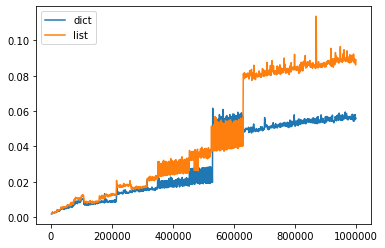

In [75]:
plt.plot(xrange[1:], dict_time[1:], label='dict')
plt.plot(xrange[1:], list_time[1:], label='list')
plt.legend()
plt.show()

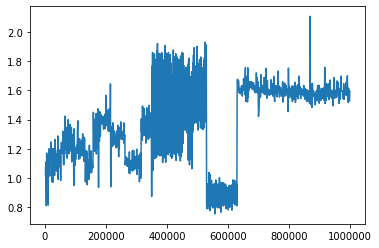

In [76]:
plt.plot(xrange[1:], ratios[1:])
plt.show()

In [ ]:
import coordle_backend
reload(coordle_backend)
from coordle_backend import CordDoc, Index2, RecursiveDescentParser, AI_Index2
Index = Index2

queries = [
    'retarded!!!',
#     '(',
#     ')',
    'retarded (white AND (woman NOT man))',
    'retarded (white AND white) man',
#     'retarded OR white OR woman',
#     'retarded white AND woman',
#     'retarded OR white NOT woman',
#     'retarded (white NOT woman)',
#     'retarded (white NOT woman)',
#     'OR retarded AND white woman',
#     'retarded AND AND white NOT woman',
#     'retarded (white NOT woman) AND',
#     ')retarded ((white NOT woman) AND',
#     'retarded ((white NOT woman)',
#     'AND retarded)) ((white NOT woman) NOT',
]

rdp = RecursiveDescentParser(index.docmap)
for query in queries:
    errmsgs = []
    tokens = rdp.get_logical_querytokens(query)
    pass_ = rdp.assert_query(tokens, errmsgs)
    
#     print(tokens)
    print(rdp.parenthesis_handler(tokens))
#     print(errmsgs)
    print(pass_)
    print()
    